<a href="https://colab.research.google.com/github/sakamrani2020/Eye_Disease_Classification/blob/main/Eye_Disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Eye_Disease_Classification using CNN**

Eye disease dataset that contains 5 classes of  eye disease images,They are:
**1)Bulging_Eyes  2)cataracts  3)Crossed_Eyes  4)Glaucoma  5)Uveitis**

In [ ]:
import os
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.environ["KAGGLE_CONFIG_DIR"]="/content/drive/MyDrive/kaggle_d"

In [ ]:
!kaggle datasets download -d kondwani/eye-disease-dataset

 81% 4.00M/4.96M [00:01<00:00, 4.41MB/s]
100% 4.96M/4.96M [00:01<00:00, 3.83MB/s]


In [ ]:
Zip_ref=zipfile.ZipFile("/content/eye-disease-dataset.zip")
Zip_ref.extractall("/tmp")
Zip_ref.close()

In [ ]:
!pip install pyTelegramBotAPI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyTelegramBotAPI: filename=pyTelegramBotAPI-4.12.0-py3-none-any.whl size=213954 sha256=3cff177ae9cc8e57ff4ee511bf526e6954a6f5169ebe819ead5772f691155848
  Stored in directory: /root/.cache/pip/wheels/7e/ba/82/f3ab5bc48525778633bccc741c0424677ed3435736221819f4
Successfully built pyTelegramBotAPI


In [ ]:
import os
import numpy as np
import tensorflow as tf
import telebot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image

# Step 1: Set up paths and parameters
data_path = "/tmp/Eye_diseases"  # Path to your dataset folder
input_shape = (128, 128, 3)  # Adjust the input shape based on your dataset images' dimensions
batch_size = 32
epochs = 20

# Step 2: Preprocess the image data using data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Change to 'binary' for binary classification
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Change to 'binary' for binary classification
    subset='validation'
)

# Step 3: Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))  # Output layer with softmax for multi-class classification

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
callbacks = [EarlyStopping(patience=3), ModelCheckpoint('eye_disease_model.h5', save_best_only=True)]
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=callbacks)

# Step 5: Evaluate the model and get the test accuracy
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    data_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test accuracy:", test_accuracy)

# Step 6: Telegram Bot Integration
TELEGRAM_BOT_TOKEN = '6313567275:AAFPvY28TJRwAvmwCYeYMfqaHMTPTT_kgJE'
TELEGRAM_CHAT_ID = '1625076925'

# Create the Telegram bot
bot = telebot.TeleBot(TELEGRAM_BOT_TOKEN)

@bot.message_handler(commands=['start', 'help'])
def send_welcome(message):
    bot.reply_to(message, "Welcome! Please send me an eye image for disease prediction.")

@bot.message_handler(content_types=['photo'])
def handle_image(message):
    try:
        file_id = message.photo[-1].file_id
        file_info = bot.get_file(file_id)
        downloaded_file = bot.download_file(file_info.file_path)

        # Save the received image
        image_path = 'received_image.jpg'
        with open(image_path, 'wb') as f:
            f.write(downloaded_file)

        # Load and preprocess the image
        img = Image.open(image_path).resize(input_shape[:2])
        img = np.array(img) / 255.0
        img = np.expand_dims(img, axis=0)

        # Make predictions
        class_indices = train_generator.class_indices
        inv_class_indices = {v: k for k, v in class_indices.items()}
        predicted_class_index = np.argmax(model.predict(img))
        predicted_class = inv_class_indices[predicted_class_index]

        # Send the predicted disease back to the user
        bot.reply_to(message, f"The predicted disease is: {predicted_class}")
    except Exception as e:
        bot.reply_to(message, "Oops! Something went wrong. Please try again.")

bot.polling()


Found 308 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
Epoch 1/20
10/10 [==============================] - 20s 448ms/step - loss: 1.5360 - accuracy: 0.3799 - val_loss: 1.3736 - val_accuracy: 0.4533
Epoch 2/20
10/10 [==============================] - 2s 170ms/step - loss: 1.4417 - accuracy: 0.4545 - val_loss: 1.3925 - val_accuracy: 0.4533
Epoch 3/20
10/10 [==============================] - 2s 254ms/step - loss: 1.4301 - accuracy: 0.4383 - val_loss: 1.3516 - val_accuracy: 0.4667
Epoch 4/20
10/10 [==============================] - 3s 307ms/step - loss: 1.3485 - accuracy: 0.4773 - val_loss: 1.3134 - val_accuracy: 0.4667
Epoch 5/20
10/10 [==============================] - 2s 179ms/step - loss: 1.3357 - accuracy: 0.4870 - val_loss: 1.2790 - val_accuracy: 0.5067
Epoch 6/20
10/10 [==============================] - 2s 171ms/step - loss: 1.3172 - accuracy: 0.5000 - val_loss: 1.3198 - val_accuracy: 0.4800
Epoch 7/20
10/10 [==============================] - 2s 180ms/step 

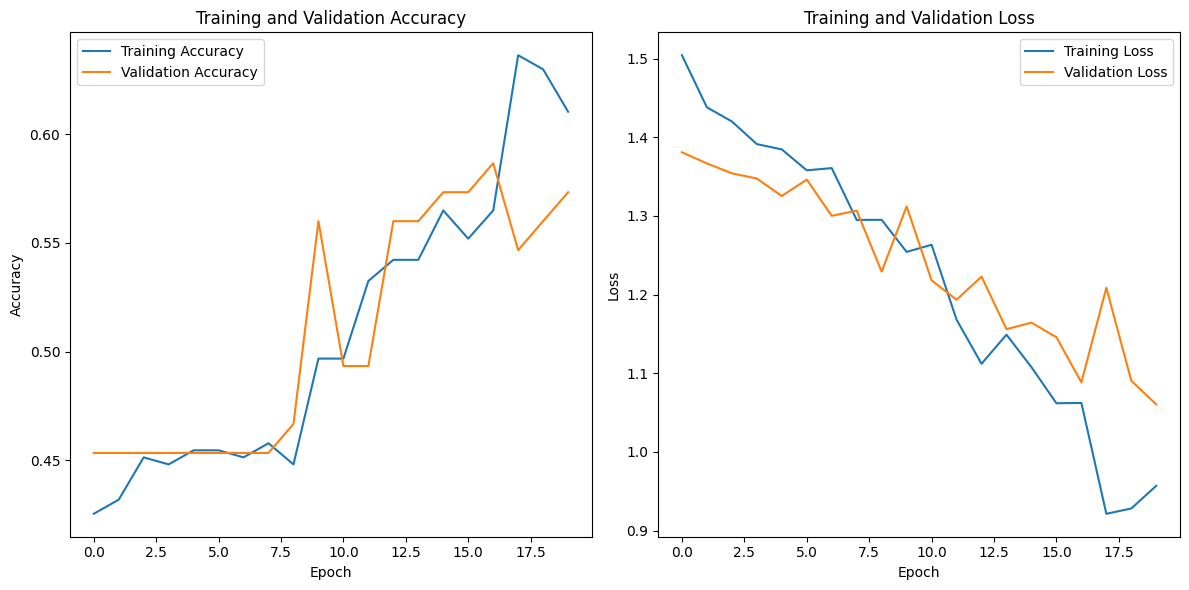

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
print("\n\n")
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()